In [35]:
import pandas as pd
from pandas_datareader import data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from frdr.database.connections import engine,session

# Set date range (Powell: 2018–2025)
start_date = '2006-01-01'
end_date = '2025-05-12'

# 1. Fetch External Data
# Override pandas-datareader to use FRED
import pandas_datareader.data as web
web.DataReader = pdr.DataReader

# 10-Year Treasury Yield (FRED: DGS10)
treasury_yield = web.DataReader('DGS10', 'fred', start_date, end_date)
treasury_yield = treasury_yield.rename(columns={'DGS10': 'Yield'})

# Federal Funds Rate (FRED: DFF)
ffr = web.DataReader('DFF', 'fred', start_date, end_date)
ffr = ffr.rename(columns={'DFF': 'FedFundsRate'})

In [36]:
speech_analysis_data = pd.read_sql("""
select chair,speaker, date, emphasis ,title 
from fed_speech_analysis fsa join
fed_speeches fs2 on fs2.id = fsa.speech_id
""",engine)

speech_data = speech_analysis_data[speech_analysis_data['chair'] == 'Jerome Powell']
speech_data['inflation'] = speech_analysis_data['emphasis'].apply(lambda x: x['inflation'])
speech_data['employment'] = speech_analysis_data['emphasis'].apply(lambda x: x['employment'])
speech_data['other'] = speech_analysis_data['emphasis'].apply(lambda x: x['other'])
speech_data['date']  =speech_analysis_data['date']
# 3. Merge Data
# Set speech dates as index
speech_data = speech_data.set_index('date')

# Merge with yield and federal funds rate
data = treasury_yield.join(ffr, how='outer')
all_data = data.join(speech_data, how='left')

#data = data.join(speech_data[['inflation', 'employment', 'other']], how='left')

# Forward-fill market data for non-trading days
all_data[['Yield', 'FedFundsRate']] = all_data[['Yield', 'FedFundsRate']].ffill()

# 4. Event-Study Setup
# Filter speech days
events = all_data.dropna(subset=['inflation', 'employment', 'other'])

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/3237913458.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_data['inflation'] = speech_analysis_data['emphasis'].apply(lambda x: x['inflation'])
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/3237913458.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_data['employment'] = speech_analysis_data['emphasis'].apply(lambda x: x['employment'])
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/32379134

In [42]:
events.to_csv('events.txt')

In [40]:
events.to_string('events.txt')

In [26]:
df = events

# Filter for Jerome Powell's speeches
#powell_df = df[df['speaker'] == 'Chairman Jerome H. Powell'].copy()
powell_df=df

In [27]:
df['speaker'] = df['speaker'].str[:20]

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/2676260328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speaker'] = df['speaker'].str[:20]


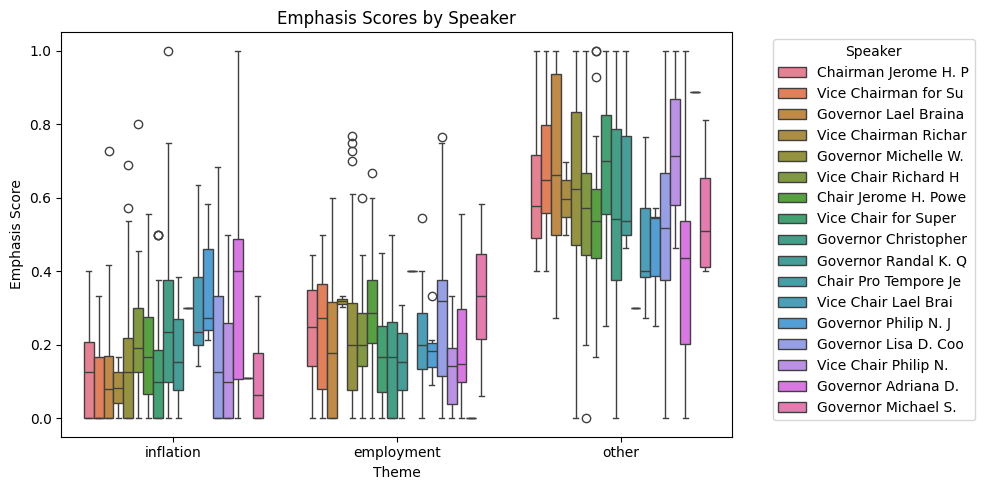

In [28]:

# 1. Box Plot of Emphasis Scores by Speaker
plt.figure(figsize=(10, 5))
df_melted = df.melt(id_vars=['speaker'], value_vars=['inflation', 'employment', 'other'],
                    var_name='Theme', value_name='Emphasis')
sns.boxplot(x='Theme', y='Emphasis', hue='speaker', data=df_melted)
plt.title('Emphasis Scores by Speaker')
plt.xlabel('Theme')
plt.ylabel('Emphasis Score')
plt.legend(title='Speaker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emphasis_by_speaker.png')
plt.show()
plt.close()

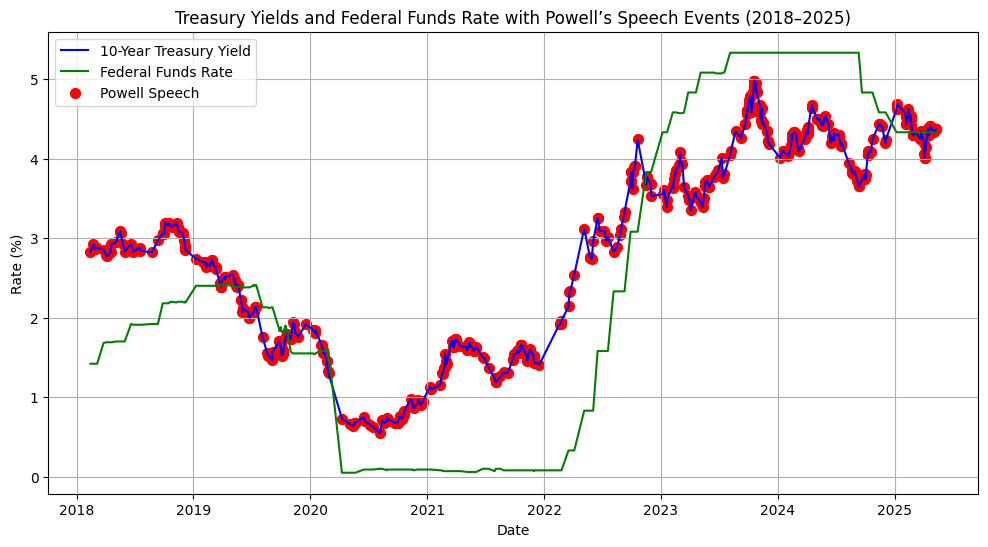

In [29]:

# 2. Time Series of Yields and Fed Funds Rate with Speech Events
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Yield'], label='10-Year Treasury Yield', color='blue')
plt.plot(df.index, df['FedFundsRate'], label='Federal Funds Rate', color='green')
# Mark Powell's speech dates
plt.scatter(powell_df.index, powell_df['Yield'], color='red', marker='o', label='Powell Speech', s=50)
plt.title('Treasury Yields and Federal Funds Rate with Powell’s Speech Events (2018–2025)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.savefig('yields_speech_events.png')
plt.show()

plt.close()

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/2851066900.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_emphasis = powell_df.resample('Y')[['inflation', 'employment', 'other']].mean()


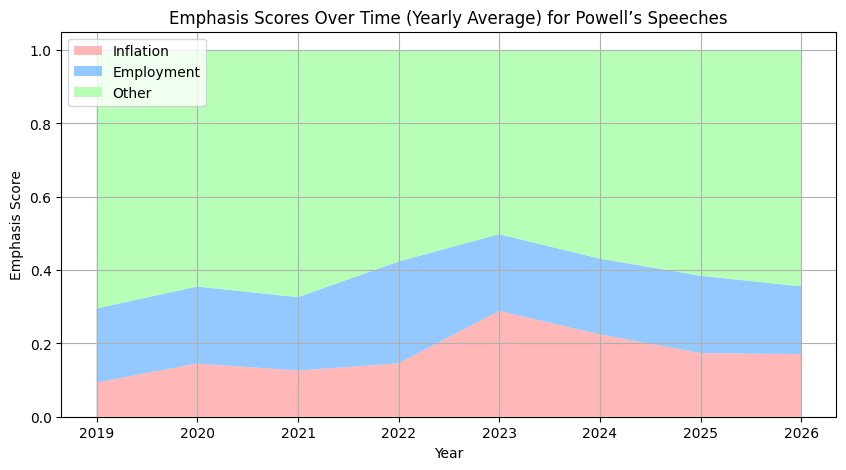

In [30]:

# 3. Stacked Area Chart of Emphasis Scores Over Time (Yearly Average)
yearly_emphasis = powell_df.resample('Y')[['inflation', 'employment', 'other']].mean()
plt.figure(figsize=(10, 5))
plt.stackplot(yearly_emphasis.index, yearly_emphasis['inflation'], yearly_emphasis['employment'], yearly_emphasis['other'],
              labels=['Inflation', 'Employment', 'Other'], colors=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.7)
plt.title('Emphasis Scores Over Time (Yearly Average) for Powell’s Speeches')
plt.xlabel('Year')
plt.ylabel('Emphasis Score')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('emphasis_stacked_area.png')
plt.show()
plt.close()


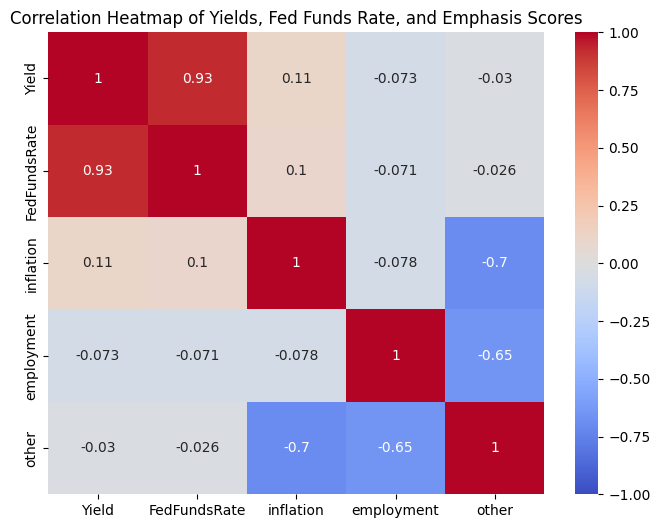

In [31]:

# 4. Correlation Heatmap of Numeric Variables
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Yield', 'FedFundsRate', 'inflation', 'employment', 'other']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Yields, Fed Funds Rate, and Emphasis Scores')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/1217361369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powell_df['year'] = powell_df.index.year


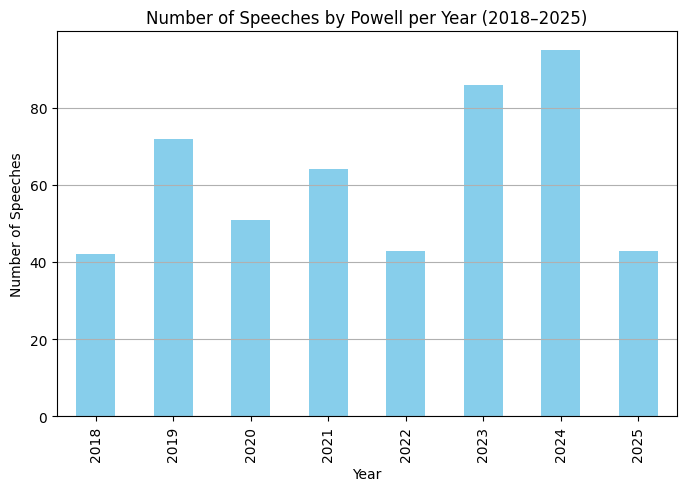

In [32]:
# 5. Speech Frequency by Year
powell_df['year'] = powell_df.index.year
speech_counts = powell_df['year'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
speech_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Speeches by Powell per Year (2018–2025)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.grid(True, axis='y')
plt.savefig('speech_frequency.png')
plt.show()
plt.close()

In [33]:
# 6. Summary Statistics (for reference in paper)
stats = powell_df[['inflation', 'employment', 'other']].describe()
stats_summary = stats.loc[['mean', 'std', 'min', 'max']].T
stats_summary.to_csv('emphasis_stats.csv', index=True)
plt.show()
print("Summary Statistics for Powell's Speeches:")
print(stats_summary)

Summary Statistics for Powell's Speeches:
                mean       std  min    max
inflation   0.172800  0.179123  0.0  1.000
employment  0.214294  0.168456  0.0  0.769
other       0.612895  0.236115  0.0  1.000
